# Deep Learning Models (LSTM & GRU)

### Libraries

In [606]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, InputLayer, GRU, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import plotly.graph_objects as go
import matplotlib.pyplot as plt

parameters = {
    "dataset":{
        "path": "../data/Processed_Data/Demand_Dataset.csv",
        "trainingSize": .70,
        "validationSize": .15,
        "testSize": .15
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    },
    "lstm":{
        "epochs": 50,
        "batch_size": 64
    }
}

In [607]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15188180219617875536
xla_global_id: -1
]


### Read and Split Dataset

In [608]:
#Read df
df = pd.read_csv(parameters['dataset']['path'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         70080 non-null  object 
 1   Demand                       70080 non-null  int64  
 2   Temperature                  70080 non-null  float64
 3   Relative_Humidity            70080 non-null  float64
 4   Precipitation_Total          70080 non-null  float64
 5   Sunshine_Duration            70080 non-null  float64
 6   Shortwave_Radiation          70080 non-null  float64
 7   Direct_Shortwave_Radiation   70080 non-null  float64
 8   Diffuse_Shortwave_Radiation  70080 non-null  float64
 9   Year                         70080 non-null  int64  
 10  Month                        70080 non-null  int64  
 11  Hour                         70080 non-null  int64  
 12  DayOfWeek                    70080 non-null  int64  
 13  DayOfYear       

In [ ]:
#Add N Lags
def addLags(df, lags):
    pass

In [609]:
#Drop Columns
dates = df["Date"]
df = df.drop("Date", axis = 1)

In [610]:
#Change Data Types
def parseData(df):
    for col in df:
        df[col] = df[col].astype(float)
    return df

#Normalize Data
def normalizeData(df):
    scaler = MinMaxScaler()
    df_normalized = scaler.fit_transform(df)
    return pd.DataFrame(df_normalized, columns=df.columns)

In [611]:
#Convert to float
df = parseData(df)

#Separate X and y
y = df["Demand"]
X = df.drop("Demand", axis = 1)
X_columns = np.array(X.columns)

#Normalize Data
#X = normalizeData(X)

#Convert df to np
X, y = X.to_numpy(), y.to_numpy()

#Split Dataset
trainingSize = int(parameters["dataset"]["trainingSize"] * X.shape[0])
validationSize = int(parameters["dataset"]["validationSize"] * X.shape[0]) + trainingSize

X_train, y_train = X[:trainingSize], y[:trainingSize]
X_val, y_val = X[trainingSize : validationSize], y[trainingSize : validationSize]
X_test, y_test = X[validationSize:], y[validationSize:]

X_train_dates = dates.loc[:trainingSize]
X_validation_dates = dates.loc[trainingSize:validationSize]
X_test_dates = dates.loc[validationSize:]    

#Reshape Datasets
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(f"Training ==> X Shape: {X_train.shape}, y Shape: {y_train.shape}")
print(f"Validation ==> X Shape: {X_val.shape}, y Shape: {y_val.shape}")
print(f"Test ==> X Shape: {X_test.shape}, y Shape: {y_test.shape}")

Training ==> X Shape: (49056, 20, 1), y Shape: (49056, 1)
Validation ==> X Shape: (10512, 20, 1), y Shape: (10512, 1)
Test ==> X Shape: (10512, 20, 1), y Shape: (10512, 1)


### <b>Plots</b>

#### Predictions & Real Values

In [612]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

#### Plot Losses 

In [613]:
def plotLosses(train_loss, validation_loss):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_loss, name="Training Loss", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_loss, name="Validation Loss", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title = "Training and Validation Losses",
        xaxis_title = "Epoch",
        yaxis_title = "MSE Loss Value",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

#### Plot Metrics

In [614]:
def plotMetrics(train_rmse, validation_rmse, train_mae, validation_mae):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_rmse, name="Training RMSE", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_rmse, name="Validation RMSE", mode="lines")
    trace3 = go.Scatter(x=epochs_list, y=train_mae, name="Training MAE", mode="lines")
    trace4 = go.Scatter(x=epochs_list, y=validation_mae, name="Validation MAE", mode="lines")

    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)
    fig.add_trace(trace4)
    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = "RMSE / MAE",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

### Find Best Models

In [615]:
def selectModels(model_params, data, parameters):
    X_train, y_train = data["train"]["X"], data["train"]["y"]
    X_val, y_val = data["validation"]["X"], data["validation"]["y"]
    X_test, y_test = data["test"]["X"], data["test"]["y"]
    results = pd.DataFrame(columns=["Model", "nUnits", "nLayers", "dropout", "Loss_All", "MAE", "RMSE"])
    for param in tqdm(ParameterGrid(model_params), total=len(list(ParameterGrid(model_params)))):
        units = param.get('nUnits')
        layers = param.get("nLayers")
        dropout = param.get("dropout")
        days = param.get("days")
        #Build LSTM Model
        lstm_model = Sequential()
        for _ in range(layers - 1):
            lstm_model.add(LSTM(units=units, return_sequences=True, dropout=dropout))
        lstm_model.add(LSTM(units=units, dropout=dropout))
        lstm_model.add(Dense(1))

        #Compile LSTM Model
        lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
        lstm_model.fit(X_train, y_train, epochs = parameters["lstm"]["epochs"], batch_size = parameters["lstm"]["batch_size"], validation_data=(X_val, y_val), verbose=False)

        #Eval LSTM Model
        lstm_loss, lstm_mae, lstm_rmse = lstm_model.evaluate(
            x = X_test,
            y = y_test,
            batch_size = parameters["lstm"]["batch_size"],
            verbose=False
        )
        results.loc[len(results.index)] = ['LSTM', units, layers, dropout, lstm_loss, lstm_mae, lstm_rmse] 

        #Build GRU Model
        gru_model = Sequential()
        for _ in range(layers - 1):
            gru_model.add(GRU(units=units, return_sequences=True, dropout=dropout))
        gru_model.add(GRU(units=units, dropout=dropout))
        gru_model.add(Dense(1))

        #Compile GRU Model
        gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
        gru_model.fit(X_train, y_train, epochs = parameters["lstm"]["epochs"], batch_size = parameters["lstm"]["batch_size"], validation_data=(X_val, y_val), verbose=False)

        #Eval GRU Model
        gru_loss, gru_mae, gru_rmse = gru_model.evaluate(
            x = X_test,
            y = y_test,
            batch_size = parameters["lstm"]["batch_size"],
            verbose=False
        )
        results.loc[len(results.index)] = ['GRU', units, layers, dropout, gru_loss, gru_mae, gru_rmse] 

    return results.sort_values(by=["RMSE", "MAE"])

data = {
    "train" : { "X" : X_train, "y" : y_train },
    "validation": { "X" : X_val, "y" : y_val },
    "test": { "X" : X_test, "y": y_test}
}

models_params = {
    'nUnits': [32, 64, 128],     
    'nLayers': [1, 2, 3],        
    'dropout': [0.0, 0.1, 0.2]
}

#results = selectModels(models_params, data, parameters)
#results

### <b>Train One Model</b>

#### Select Model

In [616]:
#Choose Model
def get_LSTM_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(LSTM(n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

def get_GRU_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(GRU(units=n_units, kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(GRU(n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

model = get_GRU_Model(X_train.shape[1], 64, 1, 0.0)
model.summary()

Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_101 (GRU)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Compile Model

In [617]:
#Comp
cp = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_root_mean_squared_error', mode='max', verbose=False)
model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[
        MeanAbsoluteError(),
        RootMeanSquaredError()
    ]
)

#### Train Model

In [618]:
train_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=parameters["lstm"]["epochs"],
    batch_size = parameters["lstm"]["batch_size"],
    callbacks=[cp]
)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 2318.9363 - mean_absolute_error: 35.6732 - root_mean_squared_error: 48.0014 - val_loss: 1752.0372 - val_mean_absolute_error: 30.3365 - val_root_mean_squared_error: 41.8573
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 1818.5260 - mean_absolute_error: 31.0568 - root_mean_squared_error: 42.6425 - val_loss: 1682.4468 - val_mean_absolute_error: 29.6270 - val_root_mean_squared_error: 41.0176
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 1780.4546 - mean_absolute_error: 30.5780 - root_mean_squared_error: 42.1930 - val_loss: 1717.9904 - val_mean_absolute_error: 30.6811 - val_root_mean_squared_error: 41.4486
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 1706.0573 - mean_absolute_error: 29.9004 - root_mean_squared_error: 41.2995 - val_loss: 1809.0767 - val_mean_absolute_error: 32.7647 - val_root_mean_squared_error: 42.5332
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 17

#### Evaluate Model 

In [619]:
test_history = model.evaluate(
    x = X_test,
    y = y_test,
    batch_size = parameters["lstm"]["batch_size"],
)
predictions = model.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1301.0542 - mean_absolute_error: 25.8459 - root_mean_squared_error: 35.6994
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [620]:
plotPredictions(X_test_dates, predictions.flatten(), y_test.flatten())

In [621]:
plotLosses(train_history.history["loss"], train_history.history["val_loss"])

In [622]:
plotMetrics(train_history.history["root_mean_squared_error"], train_history.history["val_root_mean_squared_error"], train_history.history["mean_absolute_error"], train_history.history["val_mean_absolute_error"])

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


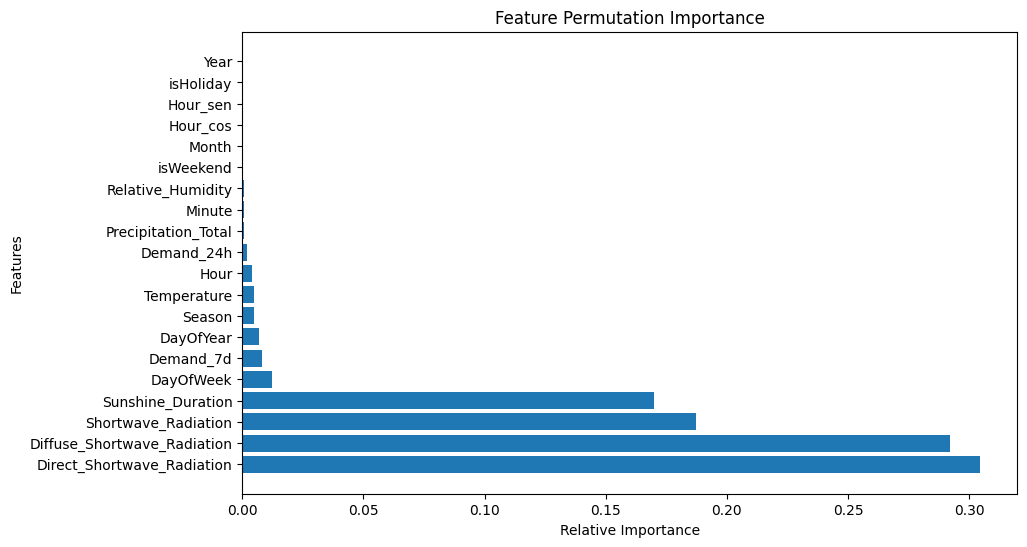

In [623]:
from sklearn.utils import shuffle
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test, verbose=False)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test.flatten(), y_pred.flatten())

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted, verbose=False)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test.flatten(), y_pred_permuted.flatten())

        #Calculate the difference in the metrics
        feature_importance[i] = np.abs(mae_ref - mae_permuted)
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

permutation_feature_importance(model, X_test, y_test, X_columns)

In [624]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler)

model = get_GRU_Model(X_train.shape[1], 64, 1, 0.0)


model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[
        MeanAbsoluteError(),
        RootMeanSquaredError()
    ]
)
train_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=parameters["lstm"]["epochs"],
    batch_size = parameters["lstm"]["batch_size"],
    callbacks=[scheduler_callback]
)
predictions = model.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
)
test_history = model.evaluate(
    x = X_test,
    y = y_test,
    batch_size = parameters["lstm"]["batch_size"],
)
plotPredictions(X_test_dates, predictions.flatten(), y_test.flatten())
print("MAE: ", mean_absolute_error(y_true=y_test.flatten(), y_pred=predictions.flatten()), ", RMSE: ", root_mean_squared_error(y_true=y_test.flatten(), y_pred=predictions.flatten()))

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 2761.0366 - mean_absolute_error: 39.8837 - root_mean_squared_error: 52.1327 - val_loss: 1599.7061 - val_mean_absolute_error: 27.0551 - val_root_mean_squared_error: 39.9963 - learning_rate: 1.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1581.9323 - mean_absolute_error: 28.0221 - root_mean_squared_error: 39.7724 - val_loss: 1570.6108 - val_mean_absolute_error: 27.4289 - val_root_mean_squared_error: 39.6309 - learning_rate: 1.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1531.1821 - mean_absolute_error: 27.0941 - root_mean_squared_error: 39.1281 - val_loss: 1532.7848 - val_mean_absolute_error: 26.4821 - val_root_mean_squared_error: 39.1508 - learning_rate: 1.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1472.0542 - mean_absolute_error: 26.4568 - root_mean_squared_error: 38.3654 - val_loss: 1516.9500 - val_mean_absolute_error: 26.0951 - val_root_mean_square

MAE:  22.203823018360875 , RMSE:  34.70013147047384


In [625]:
plotMetrics(train_history.history["root_mean_squared_error"], train_history.history["val_root_mean_squared_error"], train_history.history["mean_absolute_error"], train_history.history["val_mean_absolute_error"])

100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


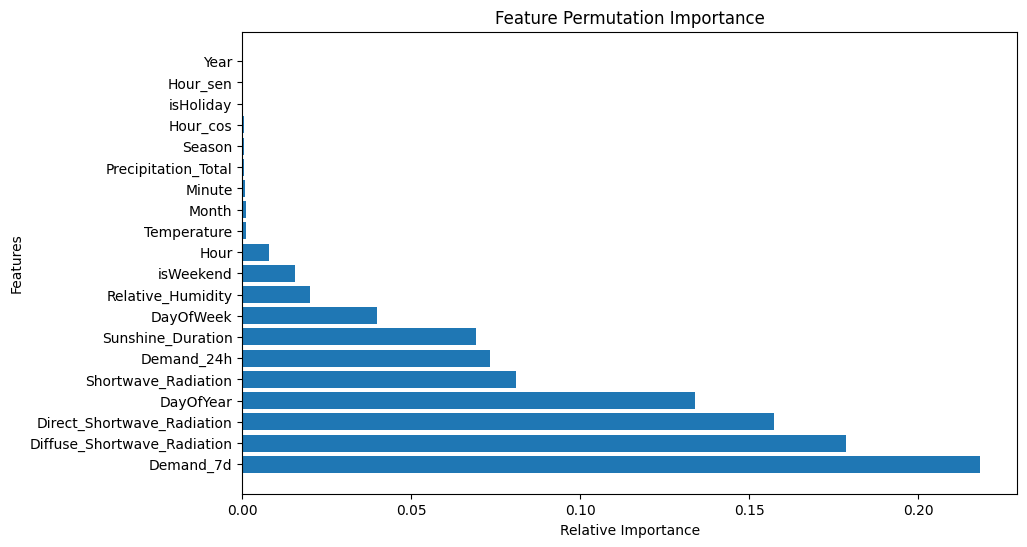

In [626]:
permutation_feature_importance(model, X_test, y_test, X_columns)